# 1. tool (5 баллов)

В этом блоке вам нужно будет написать две функции для анализа методов приближенного поиска ближайших соседей. Без этих функций использование таких методов довольно затруднительно.

Также, эти функции пригодятся вам при выполнении следующего блока.

Их нужно будет написать в `utils.py`, после чего импортировать в этот ноутбук для использования. Также, в `utils.py` вас ждут некоторые готовые функции, которые пригодятся вам в этой домашке.

Блок будет оцениваться по стандартным tool-правилам. Не забывайте про докстринги, комменты к коду, адекватность. Ориентируйтесь на примеры - они правильные :)

Все что вы напишете в рамках этого задания и все, что уже написано за вас - очень пригодится вам в будущем, обязательно сохраняйте это себе!

## 1.1 `plot_ann_performance` (3 балла)

Нужно написать функцию, которая специальным образом принимает на вход несколько "алгоритмов" приближенного поиска соседей, а также индекс для точного поиска соседей, после чего рисует на графике качество и скорость приближенного поиска для каждого из переданных алгоритмов, а также время построения индексов. Под качеством будем подразумевать `recall@k` - долю правильно найденных соседей (сравниваем с точным поиском). Функция подсчета качества вам дана; она также возвращает ошибки, которые вам понадобятся для второй функции. 

Итак, функция должна принимать:
- `build_data`, на которой будут строиться индексы подаваемых на вход алгоритмов
- `query_data`, для которой будут искаться соседи
- `index_dict`: словарик {'index_name': словарик с необходимым*, ...} с необходимой инфой для каждого из исследуемых алгоритмов aNN (см. пример)
- `k` для меры качества
- `flat_build_func`: функция, которая строит Flat-индекс (см. пример)
- `flat_search_func`: функция, которая ищет в Flat-индексе (см. пример)
- `query_in_train`: флаг того, что query_data содержится в build_data. Если это так, мерим качество по k соседям без учета
    ближайшего
- `qps_line`: float. Если указано, нарисуем горизонтальную линию по этому значению
- `recall_line`: float. Если указано, нарисуем вертикальную линию по этому значению
- `title`: str. Если указан, сделать у графика такой title 

Функционал:
- каждый алгоритм задается `fixed_params` и несколькими значениями `speed_param`. Индекс строится по fixed_params, поиск производится с параметром поиска speed_param. Для каждой пары (fixed_params, speed_param_i) у кривой, соотв. индексу, появляется точка на графике.
- эти точки надо подписывать (см. пример) напр. с помощью `ax.annotate`
- скорость поиска измеряется в queries / sec
- нужно отрисовать линию скорости FlatIndex
- нужно вывести в отдельный ax время построения каждого из индексов (напр. в виде barplot)


Остальное:
- сложнее понять задание, чем написать функцию :)
- примеры `build_func`, `search_func` находятся в `index.py`. Там же следует писать и остальные требуемые функции подобного рода.
- в этой домашке в качестве Flat индекса всегда будем передавать `faiss.IndexFlatX`
- не забывайте удалять уже ненужные индексы - они занимают память
- это ничего, что speed_params налазят друг на друга на графике
- следите за размером шрифтов и линий

In [1]:
from utils.utils import plot_ann_performance, analyze_ann_method
from utils.index import *
from functools import partial
import numpy as np

n = 10000
dim = 25

np.random.seed(911)
X = np.random.randn(n, dim)

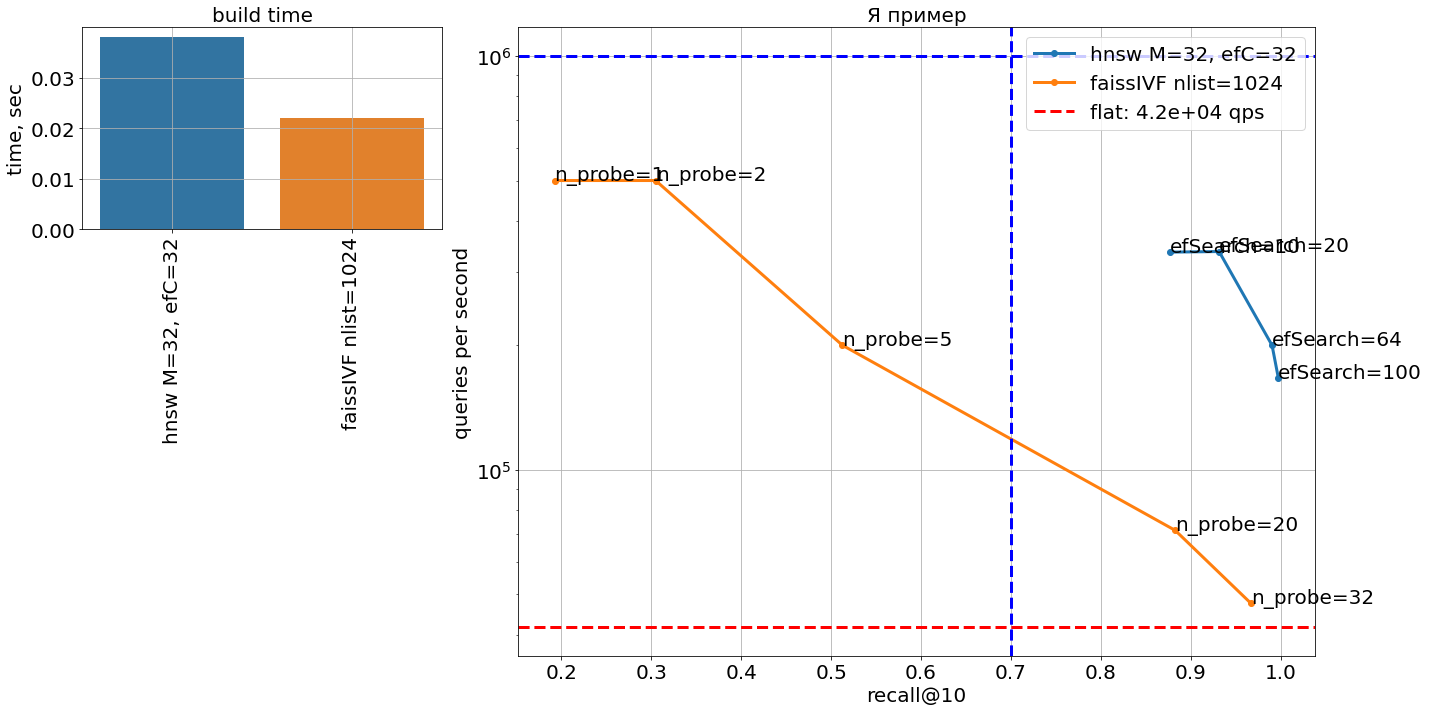

In [2]:
# ПРИМЕР, НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ

index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVF,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=X,
    query_data=X[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я пример',
    qps_line=1e6,
    recall_line=0.7
)

In [ ]:
# В качестве примера работы вашей функции, добавьте в index_dict еще какой-нибудь faiss.IndexIVFPQ с l2 метрикой
    # с разными nprobe и запустите с теми же аргументами
    

## 1.2 `analyze_ann_method` (2 балла)

Нужно написать функцию, которая специальным образом принимает на вход один алгоритм приближенного поиска соседей, после чего рисует на графике распределение количества ошибок для этого алгоритма. Под алгоритмом понимается фиксированная пара (index, search_param).
Функция `calc_recall` для каждого объекта из query_data подсчитывает, сколько ошибочных соседей было найдено для этого объекта, после чего возвращает эти ошибки, если ее попросить. Используйте это.

Аргументы можете наблюдать в примере.

Функционал:
- распределение ошибок
- подписать бины (напр. `barContainer = ax.bar(...)` -> `ax.bar_label(barContainer, ...)`)
- чистые нули отобразить чем-то отрицательным
- где-нибудь разместить информацию о времени построения индекса, скорости поиска и качестве (см. пример - легенда)

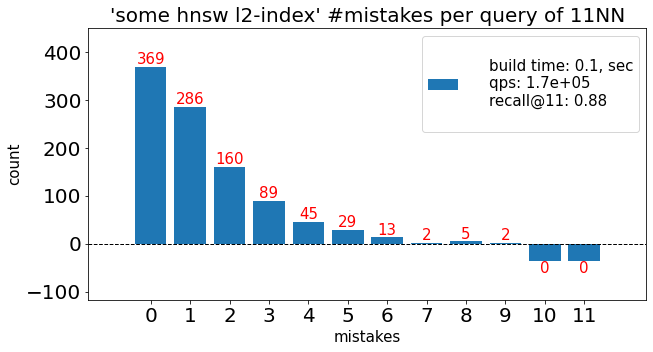

In [4]:
# ПРИМЕР, НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ

analyze_ann_method(
    build_data=X,
    query_data=X[:1000],
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32}),
    search_func=partial(search_hnsw, efSearch=10),
    k=11,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    index_name='some hnsw l2-index'
)

In [32]:
# В качестве примера работы вашей функции можете запустить на тех же аргументах

# 2. Кейсы (4 балла)

В данном блоке вам предстоит "решить" три кейса (мини-задачки с разными датасетами), используя написанные инструменты.
Задания даны под каждым кейсом. Оценивается как правильность решения, так и адекватность рассуждений.


В этом ноутбуке следует приводить только те графики / ячейки / куски кода, которые вам нужны для конечных рассуждений. Любая исследовательская работа, напрямую не относящаяся к вашим словам, должна быть выполенена в другом ноутбуке, который тоже нужно прикрепить. На другой ноутбук можно ссылаться вроде "Я много чего протестировал (см. ноутбук research), там все плохо было, а вот ХОРОШО уже тут...".

Для начала запустите ячейки ниже - там функция, которая подгружает необходимые данные.

In [1]:
# !pip install h5py

In [2]:
import numpy as np
import h5py
from urllib.request import urlretrieve
import os

%load_ext autoreload
%autoreload 2

def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test'])

## 2.1 GloVe

Датасет содержит векторы-представления некоторых слов

In [3]:
tr, tst = get_ann_benchmark_data('glove-25-angular')
tr.shape, tst.shape

((1183514, 25), (10000, 25))

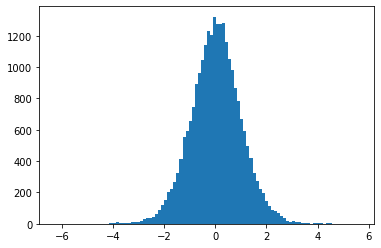

In [4]:
import matplotlib.pyplot as plt

plt.hist(tr[:1000].ravel(), bins=100)
plt.show()

**Задание:**

Представьте, что вам будут поступать онлайн-запросы с векторами такой же природы (полученными из слов тем же образом). Запросы поступают батчами, вам нужно для каждого батча в режиме реального времени возвращать 10 ближайших из трейна соседей по евклидовой метрике. Запросов очень много, они поступают непрерывно.


Вам нужно построить оптимальные индексы на тренировочных данных, решающие задачу и удовлетворяющие требованию:
1. минимальная скорость на возврат соседей равна `10 * flat_l2_qps` queries / sec `(один индекс для этого требования)`
2. получить максимальное качество соседей (все, что лучше recall@10=0.99 считаем за идеальное качество) `(и один индекс для этого требования)`


- считаем, что памяти дано столько, сколько доступно лично вам при выполнении этой домашки
- "сдать" индекс надо "сегодня", поэтому "максимальное" время построения индекса - примерно 5-6 минут

Доступные индексы, которые могут стать ответом: `faiss.IndexFlat..`, `faiss.IndexIVF`, `faiss.IndexIVFPQ`, `hnswlib.Index`


<br><br>
Используйте функцию `plot_ann_performance`, чтобы определить, какой индекс лучше всего подойдет для какой задачи.
Обычно, параметры для построения индекса и поиска по нему имеют понятную интуицию трейдоффа между скоростью построения индекса, скоростью поиска, качеством найденных соседей и памятью, поэтому использовать что-то вроде optuna для подбора этих параметров - overkill, вы быстро нащупаете нужные диапазоны по графикам. Для попытки нащупать оптимальные параметры, можно использовать сэмпл меньшего размера из трейна в качестве build_data и из теста в качестве query_data, однако конечные выводы должны основываться на графиках, полученных на всех данных трейна и на достаточном количестве query-данных, чтобы оценить queries_per_second. 

Доступные индексы, которые могут стать ответом: `faiss.IndexFlatL2`, `faiss.IndexIVF`, `faiss.IndexIVFPQ`, `hnswlib.Index`

Опишите эти два индекса и причины, по которым вы сделали выбор:
- приведите необходимые графики
- напишите свои рассуждения и выводы
- проверьте адекватность распределения кол-ва ошибок - согласуется ли оно с интуицией?
- опишите также свои мысли на тему остальных индексов в контексте каждого из требований <br>


Например: "Для второй задачи лучше всего подойдет `faiss.IndexIVFPQ, nlist=1024, m=4, nbits=8`, потому что ..."


Рекомендации и интуицию по параметрам смотрите тут:
- hnsw:
    - https://github.com/nmslib/nmslib/blob/master/manual/methods.md
    - https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    - https://www.pinecone.io/learn/series/faiss/hnsw/

- faiss:
    - https://github.com/facebookresearch/faiss/wiki/

In [ ]:
# your code here

## 2.2 NYTimes

Датасет содержит векторы-представления некоторых текстов

In [5]:
tr, tst = get_ann_benchmark_data('nytimes-256-angular')
tr.shape, tst.shape

((290000, 256), (10000, 256))

**Задание:**
Постановка задачи та же, но в этом блоке вам надо ответить только на один вопрос - какую меру близости выбрать: евклидову или косинусную.

Проанализируйте с помощью `plot_ann_performance` и анализа распределения ошибок поведение `faiss.IndexIVF`, `hnswlib.Index` на обеих мерах близости на build-подвыборке в 20k, 50k сэмплов и полной build-выборке.

- [как построить IndexFlat для косинусной меры близости](https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances)

Напишите все свои рассуждения, подкрепляя их графиками, и ответьте на поставленный вопрос.

In [ ]:
# your code here

## 2.3 FashionMNIST

Датасет содержит вытянутые в один вектор картинки из датасета [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), с метками

In [6]:
import pandas as pd

tr_df = pd.read_csv('fashion-mnist_train.csv')
tst_df = pd.read_csv('fashion-mnist_test.csv')

tr = tr_df.iloc[:, 1:].values.astype(np.float32)
tst = tst_df.iloc[:, 1:].values.astype(np.float32)

tr_labels = tr_df.iloc[:, 0].values
tst_labels = tst_df.iloc[:, 0].values

del tr_df, tst_df

tr.shape, tst.shape

((60000, 784), (10000, 784))

**Задание:** выбрать три алгоритма с recall@9 приблизительно 0.6, 0.9, 0.99. Посчитать каждым из этих алгоритмов и алгоритмом точного поиска 9 ближайших по косинусной мере соседей из трейна для всех объектов теста. Предсказать итоговые метки для теста с помощью функции `knn_predict_classification`, померить `sklearn.metrics.balanced_accuracy_score`. Какие выводы можно сделать?

In [26]:
# your code here

# 3. Крабы (6 баллов)

[описание данных](https://www.kaggle.com/datasets/sidhus/crab-age-prediction) <br>
[послать ответ](https://www.kaggle.com/competitions/aim-2023-crabs/leaderboard)

В этом блоке вам предстоит полноценно решить задачу предсказания возраста крабов с помощью ближайших соседей. Данные и информацию о них можно найти по ссылкам выше. Вам нужно скачать данные, предсказать возраст наилучшим способом и отправить в kaggle. **За задание можно получить баллы только в случае побития бейслайна на паблик лидерборде.**

Задание с хорошей вероятностью включает в себя:
- анализ распределений признаков и их физического смысла
- предобработка и трансформация данных
- придумывание и воплощение в жизнь своего видения близости между крабами!
- выбор валидации и тюнинг гиперпараметров
- получение ближайших соседей для теста
- получение предсказаний для теста (проще написать свою функцию, чем разобраться в том, как это сделать через sklearn)

Важно:
- можно использовать любые индексы / методы поиска соседей (но задача спокойно решается полным перебором, так что можно не мудрить)
- можно конструировать дополнительные признаки из имеющихся данных
- нельзя пользоваться никакими другими методами машинного обучения для решения этой задачи (в т.ч. и для генерации признаков)
- нельзя использовать дополнительные данные
- в данном блоке должен быть приведен чистый (без ненужного кода / ячеек) пайплайн работы с данными, который приводит вас от 
    этапа загрузки данных к  получению предсказаний.
    Исследовательская работа, подбор гиперпараметров и прочие вещи выполняйте в другом ноутбуке, который тоже нужно будет 
    прикрепить в классрум
    
Для начала можно попробовать такой пайплайн:
- `scipy.spatial.distance.cdist` на всех числовых фичах по евклидовой метрике
- `get_k_neighbors` для взятого из головы k
- напишите `knn_predict_regression` по аналогии с классификацией и предскажите тест
- сдайте :)

In [33]:
# your code here